<a href="https://colab.research.google.com/github/sahilghogare/Ethics_in_AI-Assignments/blob/main/EthicsLab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv("federated_health_dataset.csv")
data.head()


,client_id,age,bmi,blood_pressure,cholesterol_level,glucose_level,insulin_level,physical_activity_score,diet_quality_score,risk_of_diabetes
0,client_1,58,33.114602,126.694340,223.581019,148.596955,114.456870,5.536434,1.097763,0
1,client_1,71,29.118665,137.043635,191.385797,138.994652,97.089644,3.572767,3.742142,0
2,client_1,48,26.465296,127.521401,188.760160,88.724671,76.673548,3.252099,3.350063,0
3,client_1,34,29.483152,135.909579,175.439690,28.635894,108.141970,1.747565,5.322880,0
4,client_1,62,21.948390,109.965378,181.242854,92.869358,42.654259,8.433531,5.220981,0


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = LabelEncoder().fit_transform(data[col])
data.iloc[:, :-1] = data.iloc[:, :-1].astype(float)
scaler = StandardScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])


/tmp/ipython-input-1260631530.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    4.0
996    4.0
997    4.0
998    4.0
999    4.0
Name: client_id, Length: 1000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, :-1] = data.iloc[:, :-1].astype(float)
/tmp/ipython-input-1260631530.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      58.0
1      71.0
2      48.0
3      34.0
4      62.0
       ... 
995    22.0
996    42.0
997    58.0
998    49.0
999    69.0
Name: age, Length: 1000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, :-1] = data.iloc[:, :-1].astype(float)


In [ ]:
def split_into_clients(data, num_clients):
    clients = []
    label_col = data.columns[-1]

    class0 = data[data[label_col] == 0]
    class1 = data[data[label_col] == 1]

    if num_clients == 3:
        clients.append(class0.sample(frac=0.7))
        clients.append(class1.sample(frac=0.7))
        clients.append(data.sample(frac=0.4))

    return clients
num_clients = 3
client_datasets = split_into_clients(data, num_clients)



In [ ]:
import torch
import torch.nn as nn

device = torch.device("cpu")

class HeartModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
import torch.optim as optim

def local_train(model, df, noise_scale=0.0):
    model.train()

    X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
    y = torch.tensor(df.iloc[:, -1].values, dtype=torch.long)

    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    optimizer.zero_grad()
    loss = loss_fn(model(X), y)
    loss.backward()
    optimizer.step()

    weights = model.state_dict()
    if noise_scale > 0:
        for key in weights:
            weights[key] += torch.normal(
                0, noise_scale, weights[key].shape
            )

    return weights


In [ ]:
def federated_average(weights):
    avg = {}
    for key in weights[0]:
        avg[key] = torch.stack(
            [w[key] for w in weights]
        ).mean(dim=0)
    return avg


In [ ]:
def federated_learning(data, rounds, noise):
    clients = split_into_clients(data, 3)
    input_dim = data.shape[1] - 1
    global_model = HeartModel(input_dim)

    accuracies = []

    print(f"\n🔹 Noise Level: {noise}")

    for r in range(rounds):
        client_weights = []

        for c in clients:
            local_model = HeartModel(input_dim)
            local_model.load_state_dict(global_model.state_dict())

            w = local_train(local_model, c, noise)
            client_weights.append(w)

        global_model.load_state_dict(
            federated_average(client_weights)
        )

        acc = evaluate(global_model, data)
        accuracies.append(acc)

        print(f"Round {r + 1} | Average Accuracy: {acc:.4f}")

    return accuracies


In [ ]:
def evaluate(model, data):
    model.eval()
    X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
    y = torch.tensor(data.iloc[:, -1].values, dtype=torch.long)

    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1)

    return (preds == y).float().mean().item()
rounds = 5

acc_0  = federated_learning(data, rounds, noise=0.0)
acc_01 = federated_learning(data, rounds, noise=0.1)
acc_05 = federated_learning(data, rounds, noise=0.5)
acc_10 = federated_learning(data, rounds, noise=1.0)




🔹 Noise Level: 0.0
Round 1 | Average Accuracy: 0.5550
Round 2 | Average Accuracy: 0.5820
Round 3 | Average Accuracy: 0.6090
Round 4 | Average Accuracy: 0.6240
Round 5 | Average Accuracy: 0.6450

🔹 Noise Level: 0.1
Round 1 | Average Accuracy: 0.9790
Round 2 | Average Accuracy: 0.9920
Round 3 | Average Accuracy: 0.9670
Round 4 | Average Accuracy: 0.9830
Round 5 | Average Accuracy: 0.9770

🔹 Noise Level: 0.5
Round 1 | Average Accuracy: 0.1750
Round 2 | Average Accuracy: 0.0340
Round 3 | Average Accuracy: 0.1740
Round 4 | Average Accuracy: 0.3730
Round 5 | Average Accuracy: 0.2440

🔹 Noise Level: 1.0
Round 1 | Average Accuracy: 0.8040
Round 2 | Average Accuracy: 0.7140
Round 3 | Average Accuracy: 0.6210
Round 4 | Average Accuracy: 0.8990
Round 5 | Average Accuracy: 0.8760


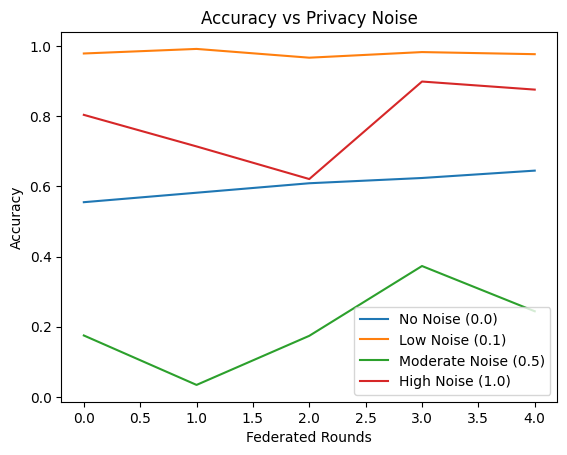

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc_0,  label="No Noise (0.0)")
plt.plot(acc_01, label="Low Noise (0.1)")
plt.plot(acc_05, label="Moderate Noise (0.5)")
plt.plot(acc_10, label="High Noise (1.0)")

plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Privacy Noise")
plt.legend()
plt.show()
